## Setup and importing modules

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import cross_validate
from tqdm import tnrange, tqdm_notebook, tqdm
from datetime import timedelta
from datetime import datetime
from sklearn import metrics

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import scipy.stats as stats
import xgboost as xgb
import requests as r
import pandas as pd
import seaborn as s
import numpy as np
import googlemaps
import postgres
import holidays
import config
import json
import math

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# parallelisation with Dask for handling large dataframe
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
PB = ProgressBar()
PB.register()

In [2]:
import importlib
importlib.reload(postgres.config)

<module 'config' from '/media/storage/College/S3/Github/DublinBus/Analytics/config.py'>

In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Import Data

### Bus Data

In [4]:
# data = postgres.query("SELECT * FROM combined;", tunnel=True)
# data = pd.DataFrame(data)

data = pd.read_csv("stored_queries/combined145.csv")

# Dask Version
# data = dd.read_csv("stored_queries/combined.csv")

# Drop duplicates 
data.drop_duplicates(inplace=True)

In [5]:
data.columns = ['dayofservice','tripid','lineid','direction','progrnumber','stopid','plannedDEP','plannedARR','actualDEP','actualARR','routeid']

In [ ]:
data.head()

In [6]:
data.drop(columns=['routeid','plannedDEP','plannedARR','actualDEP'], inplace=True)

In [7]:
# Dask Version
# data.dayofservice = dd.to_datetime(data.dayofservice.loc[:])


data.dayofservice = pd.to_datetime(data.dayofservice.loc[:])
# data.lineid = data.lineid.astype('category')
# data.routeid= data.routeid.astype('category')

In [8]:
data.sort_values(by=['dayofservice','lineid','tripid','direction','progrnumber'],inplace=True)
# data.to_csv("stored_queries/combined145.csv", index=False, chunksize=500000)

### Trips information [for full route prediction]

In [ ]:
tripsdata = pd.read_csv("stored_queries/trips_df.csv")
tripsdata.head()

In [ ]:
tripsdata = tripsdata[['dayofservice', 'tripid', 'lineid', 'routeid', 'direction', 'actual_arr', 'actual_dep']]
tripsdata.dayofservice = pd.to_datetime(tripsdata.dayofservice)
tripsdata.dropna(inplace=True)

### Stop Information

In [9]:
stops = pd.read_csv("stop_information.csv")

In [10]:
cols = list(stops.columns)
cols[0] = 'ix'
stops.columns = cols
stops.drop(columns=cols[0], inplace=True)

stops.head()

,id,stopid,stop_name,lat,lng,irish_name,routes
0,4240,2,Parnell Square,53.352241,-6.263695,Cearnóg Parnell,"['38', '38A', '38B', '38D', '46A', '46E']"
1,4241,3,Parnell Square,53.352307,-6.263783,Cearnóg Parnell,"['120', '122']"
2,4242,4,Parnell Square,53.352567,-6.264166,Cearnóg Parnell,"['7', '7A', '7B', '7D', '9']"
3,4243,6,Parnell Square,53.352744,-6.264443,Cearnóg Parnell,"['4', '155']"
4,4244,7,Parnell Square,53.352836,-6.264562,Cearnóg Parnell,"['13', '140', '40', '40B', '40D']"


### Weather Data

In [11]:
weather = pd.read_csv("stored_queries/weather.csv")

weather.head()

,dayofservice,hour,icon,temperature,humidity,cloudCover,windSpeed,rain
0,2018-01-01,0,partly-cloudy-night,41.19,0.80,0.58,17.04,0.0
1,2018-01-01,1,partly-cloudy-night,41.70,0.79,0.75,21.59,0.1
2,2018-01-01,2,partly-cloudy-night,41.95,0.78,0.75,21.59,0.0
3,2018-01-01,3,partly-cloudy-night,42.42,0.82,0.58,19.60,0.0
4,2018-01-01,4,partly-cloudy-night,42.09,0.83,0.44,20.48,0.0


In [12]:
weather.count()

dayofservice    8751
hour            8751
icon            8751
temperature     8751
humidity        8751
cloudCover      8496
windSpeed       8745
rain            8751
dtype: int64

In [13]:
weather.icon = weather.icon.astype('category')
weather.dayofservice = pd.to_datetime(weather.dayofservice)

### Export/ Import the number of stops on each lineid for basic model.

In [ ]:
# # Read in all lineids from teh database and store in a text file.


# lineids = postgres.query("Select distinct(lineid) from combined;", tunnel=True)

# q = dict()
# for lidx in tnrange(len(lineids)):
    
#     lid = lineids[lidx]
#     q[lid[0]] = postgres.query("SELECT MAX(progrnumber) FROM combined WHERE lineid='%s';" % str(lid[0]), tunnel=True)
    
# with open("stops_per_line.txt",'w') as f:
#     f.write(json.dumps(q))
# f.closed


In [ ]:
with open("stops_per_line.txt",'r') as g:
    max_stops_per_line = json.loads(g.readlines()[0])

### Import distances between stops data

In [14]:
stop_distances = pd.read_csv("stored_queries/distancedata.csv", header=None)
stop_distances.columns = ['stopid','previous_stopid','distance']
stop_distances.head()

,stopid,previous_stopid,distance
0,1636,1635,397
1,1338,1337,151
2,837,836,137
3,2740,7177,481
4,1201,4385,324


## Prepairing Data for Combining

#### Weather and leavetimes

In [15]:
# leavetimes data
# data.plannedARR = data.dayofservice + pd.to_timedelta(data.plannedARR, unit = 'seconds') # in nanoseconds
# data.plannedDEP = data.dayofservice + pd.to_timedelta(data.plannedDEP, unit = 'seconds') # in nanoseconds
data.actualARR = data.dayofservice + pd.to_timedelta(data.actualARR, unit = 'seconds') # in nanoseconds
# data.actualDEP = data.dayofservice + pd.to_timedelta(data.actualDEP, unit = 'seconds') # in nanoseconds

# new columns for combining
# data['time_at_stop'] = data.actualDEP - data.actualARR
data['weather_merge_time'] = data.actualARR.dt.round('H') #  .dt useful


# weather data
weather.dayofservice = weather.dayofservice + pd.to_timedelta(weather.hour, unit='hour')

# new column for combining
weather['rkey'] = weather.dayofservice

#### Trips data preparation

In [ ]:
tripsdata.actual_arr = tripsdata.dayofservice + pd.to_timedelta(tripsdata.actual_arr, unit='seconds')
tripsdata.actual_dep = tripsdata.dayofservice + pd.to_timedelta(tripsdata.actual_dep, unit='seconds')
tripsdata['triplength'] = tripsdata.actual_arr - tripsdata.actual_dep
tripsdata['leavehour'] = tripsdata.actual_dep.dt.hour

In [ ]:
tripsdata.head()

In [16]:
weather.head()

,dayofservice,hour,icon,temperature,humidity,cloudCover,windSpeed,rain,rkey
0,2018-01-01 00:00:00,0,partly-cloudy-night,41.19,0.80,0.58,17.04,0.0,2018-01-01 00:00:00
1,2018-01-01 01:00:00,1,partly-cloudy-night,41.70,0.79,0.75,21.59,0.1,2018-01-01 01:00:00
2,2018-01-01 02:00:00,2,partly-cloudy-night,41.95,0.78,0.75,21.59,0.0,2018-01-01 02:00:00
3,2018-01-01 03:00:00,3,partly-cloudy-night,42.42,0.82,0.58,19.60,0.0,2018-01-01 03:00:00
4,2018-01-01 04:00:00,4,partly-cloudy-night,42.09,0.83,0.44,20.48,0.0,2018-01-01 04:00:00


In [17]:
data.head()

,dayofservice,tripid,lineid,direction,progrnumber,stopid,actualARR,weather_merge_time
0,2018-01-01,5955476,145,1,1,4320,2018-01-01 08:59:30,2018-01-01 09:00:00
1,2018-01-01,5955476,145,1,2,1476,2018-01-01 09:01:01,2018-01-01 09:00:00
2,2018-01-01,5955476,145,1,3,7453,2018-01-01 09:01:48,2018-01-01 09:00:00
3,2018-01-01,5955476,145,1,4,1478,2018-01-01 09:02:52,2018-01-01 09:00:00
4,2018-01-01,5955476,145,1,5,1479,2018-01-01 09:03:50,2018-01-01 09:00:00


## Combining Data

### Combining weather and leavetimes

In [ ]:
gc.enable()
gc.get_stats()
gc.collect()

In [ ]:
data.head()

In [18]:
combinedata = data.merge(weather[['icon','temperature','humidity','windSpeed','rain','rkey','hour']], 
                         left_on='weather_merge_time', 
                         right_on='rkey', 
                         how='left')

In [19]:
# Free up memory after the data table is deleted. 
del data

import gc
gc.collect()

61

In [20]:
# drop lineid as all are 145
# combinedata.drop(columns=['rkey','lineid','weather_merge_time','plannedDEP','plannedARR','time_at_stop','actualDEP'], inplace=True)
combinedata.drop(columns=['rkey','lineid','weather_merge_time'], inplace=True)
gc.collect()

7

### Combining trips and weather

In [ ]:
tripsdata['weather_merge_time'] = tripsdata.actual_dep.dt.round('H')

In [ ]:
combinedtrip = tripsdata.merge(weather[['icon','temperature','humidity','windSpeed','rain','rkey','hour']], 
                               left_on='weather_merge_time', 
                               right_on='rkey', 
                               how='left')

## Cleaning / Adding Additional features

### Remove inactive stops from data

In [21]:
active_stopids = stops.stopid.values

# remove all inactive stops from the dataset. -> additional models that arent needed. 
combinedata = combinedata[combinedata.stopid.isin(active_stopids)]

### weekday vs weekend

In [22]:
combinedata['weekend'] = combinedata.dayofservice.dt.weekday.isin([5,6])

### holidays

In [ ]:
combinedata.count()[0]

In [23]:
ie_holidays = holidays.Ireland()
combinedata['holiday'] = combinedata.dayofservice.apply(lambda x: x in ie_holidays)

### Pair Consecutive Stop IDs 

#### Matching progrnumbers to previous stop

In [24]:
# previous stopid
previousstops =  list(combinedata.stopid)
previousstops = np.array(previousstops[:-1]).astype(int)

# progrnumber of previous stopid
previousstops_progrnumber = list(combinedata.progrnumber)
previousstops_progrnumber = np.array(previousstops_progrnumber[:-1]).astype(int)

# Actual arrival time of previous stopid
previousstops_actualARR = list(combinedata.actualARR)
previousstops_actualARR = np.array(previousstops_actualARR[:-1])

# Delete the first row of the dataframe to shift the progrnumbers by one. 
combinedata = combinedata.iloc[1:]

# garbage collection to free memory
gc.collect()

0

In [25]:
combinedata['previous_stopid'] = previousstops
combinedata['previous_stopARR'] = previousstops_actualARR
combinedata['previous_progrnumber'] = previousstops_progrnumber

In [26]:
combinedata.head()

,dayofservice,tripid,direction,progrnumber,stopid,actualARR,icon,temperature,humidity,windSpeed,rain,hour,weekend,holiday,previous_stopid,previous_stopARR,previous_progrnumber
1,2018-01-01,5955476,1,2,1476,2018-01-01 09:01:01,partly-cloudy-day,41.19,0.81,12.91,0.0,9.0,False,True,4320,2018-01-01 08:59:30,1
2,2018-01-01,5955476,1,3,7453,2018-01-01 09:01:48,partly-cloudy-day,41.19,0.81,12.91,0.0,9.0,False,True,1476,2018-01-01 09:01:01,2
3,2018-01-01,5955476,1,4,1478,2018-01-01 09:02:52,partly-cloudy-day,41.19,0.81,12.91,0.0,9.0,False,True,7453,2018-01-01 09:01:48,3
4,2018-01-01,5955476,1,5,1479,2018-01-01 09:03:50,partly-cloudy-day,41.19,0.81,12.91,0.0,9.0,False,True,1478,2018-01-01 09:02:52,4
5,2018-01-01,5955476,1,6,7622,2018-01-01 09:05:04,partly-cloudy-day,41.19,0.81,12.91,0.0,9.0,False,True,1479,2018-01-01 09:03:50,5


#### Dropping mis-matched progrnumbers

In [27]:
# Dropping rows where progrnumber==1 as the first row is currently aligned with the last row of the previous tripid.
combinedata = combinedata[combinedata.progrnumber != 1]
combinedata.dropna(inplace=True);

#### Dropping non-consecutive stop combinations

In [28]:
# recast type of integer cols from float to int. 
combinedata.previous_stopid = combinedata.previous_stopid.astype(int)
combinedata.previous_progrnumber = combinedata.previous_progrnumber.astype(int)

# make progrnumber difference column and then drop anything thats not exactly 1, removes data which skips stops. 
combinedata['progrnumber_difference'] = combinedata.progrnumber - combinedata.previous_progrnumber

# checking how many rows will be left. 
# combinedata.progrnumber_difference.value_counts()

In [29]:
# remove non-consecutive stop pairs.
combinedata = combinedata[combinedata.progrnumber_difference==1]

# Remove additional columns added for this operantion
# combinedata.drop(columns=['progrnumber','previous_progrnumber','progrnumber_difference'], inplace=True);

# ordering rows [and dropping irrelevant ones: direction, route_id]
combinedata = combinedata[['dayofservice', 'tripid','stopid', 'previous_stopid', 'actualARR', 'previous_stopARR',
                           'icon', 'temperature', 'humidity', 'windSpeed', 'rain', 'hour', 'weekend', 'holiday']]

#### Unique Stopid combinations

In [31]:
# all unique stop combinations for a given lineid.
stop_pairs = combinedata[['stopid','previous_stopid']].drop_duplicates()

# print("There are %d unique pairs of stops on line: %s" % (stop_pairs.count()[0], data.lineid.unique()[0]))

### Travel Time

In [32]:
# convert to seconds
combinedata['travel_time'] = (combinedata.actualARR - combinedata.previous_stopARR).astype(int)/10**9

# drop any values less than 5 seconds [assumed erroneous]
combinedata = combinedata[combinedata.travel_time > 5]

In [33]:
print("There are %d valid pairs" % combinedata.count()[0])

There are 3958657 valid pairs


### Distance between stops [ === Don't run again === ]

In [34]:
# Function to get the distance between two stops. 
# def get_distance(start, finish):
#     """
#     Distance between two (lat,lng) pairs
    
#     Inputs:
#     ================================
#     (int) start: stopid of first stop
#     (int) finish: stopid of last stop
    
#     Outputs:
#     ===============================
#     (int) the distance in metres between the stops. 
    
#     Notes:
#     ===============================
#     If there is an error, or the api fails to find the distance a value of None will be returned. 
#     """
#     try:
#         begin = (stops[stops.stopid==start ]['lat'].values[0], stops[stops.stopid==start ]['lng'].values[0])
#         end   = (stops[stops.stopid==finish]['lat'].values[0], stops[stops.stopid==finish]['lng'].values[0])

#     except Exception as e:

#         print(start, finish)
#         print(repr(e)) 
#         return None
        
#     API_key = config.dmatrix_key #enter Google Maps API key
#     gmaps = googlemaps.Client(key=API_key)
    
#     try:
#         call = gmaps.distance_matrix(begin, end, mode='walking')
    
#     except Exception as eL:
        
#         print(repr(eL))
#         return None
    
#     status = call['status']
    
#     if status=='OK':
#         return call["rows"][0]["elements"][0]['distance']['value']
    
#     else:
#         print(status)
#         return None

# distances_list = []

# for index, pair in tqdm_notebook(stop_pairs.iterrows(), total=stop_pairs.shape[0]):

# # for pair in stop_pairs.iterrows():
# #     start_stopid, finish_stopid = pair[1]

#     start_stopid, finish_stopid = pair[0], pair[1]
#     distances_list.append(get_distance(start_stopid, finish_stopid))
    
# distance_array = np.array(distances_list)

# stop_pairs['distance'] = distance_array

In [35]:
combinedata = combinedata.merge(stop_distances, how='left', left_on=['stopid','previous_stopid'], right_on=['stopid','previous_stopid'])
combinedata.distance = combinedata.distance.astype(int)

### Average Speed

In [36]:
# Taking average speed as distance / time (km/h)
combinedata['avgvel'] = (combinedata.distance / combinedata.travel_time) * (3600/1000)

# Note need to drop all data over 120 km/h -> erroneous data
combinedata = combinedata[combinedata.avgvel <= 120]

### Adding Month/Season

In [37]:
combinedata['month'] = combinedata.dayofservice.dt.month

def set_season(x):
    winter = [11,12,1]
    autumn = [10,9,8]
    spring = [4,3,2]

    if x in winter:
        return 'Winter'
    elif x in autumn:
        return 'Autumn'
    elif x in spring:
        return 'Spring'
    else:
        return 'Summer'
    
combinedata['season'] = combinedata.dayofservice.dt.month.apply(set_season)

## Correlation / boxplots

In [38]:
# Note: travel time is continuous but is needed for comparison
categorical_features = ['hour','holiday', 'weekend','month','season','icon']

continuous_features  = ['travel_time','distance','temperature','windSpeed','rain','humidity']

In [39]:
corr = combinedata[continuous_features].corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,travel_time,distance,temperature,windSpeed,rain,humidity
travel_time,1,0.21,0.0088,0.015,0.0015,-0.019
distance,0.21,1,-0.00095,-9.6e-05,0.00018,-0.00064
temperature,0.0088,-0.00095,1,0.081,-0.056,-0.52
windSpeed,0.015,-9.6e-05,0.081,1,0.044,-0.096
rain,0.0015,0.00018,-0.056,0.044,1,0.13
humidity,-0.019,-0.00064,-0.52,-0.096,0.13,1


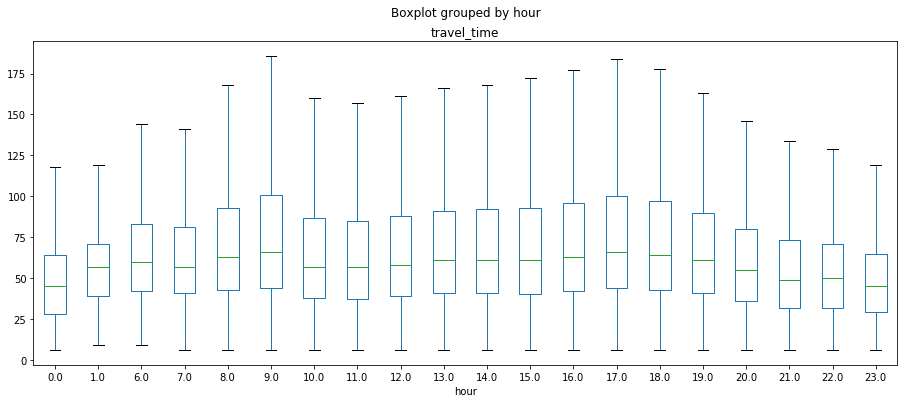

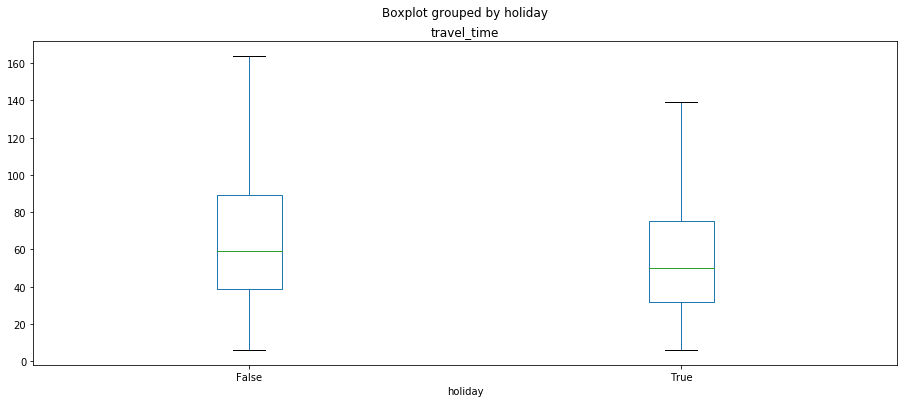

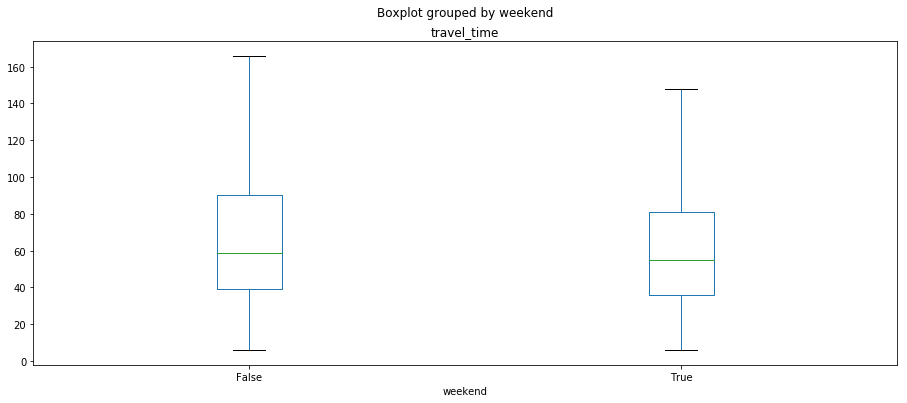

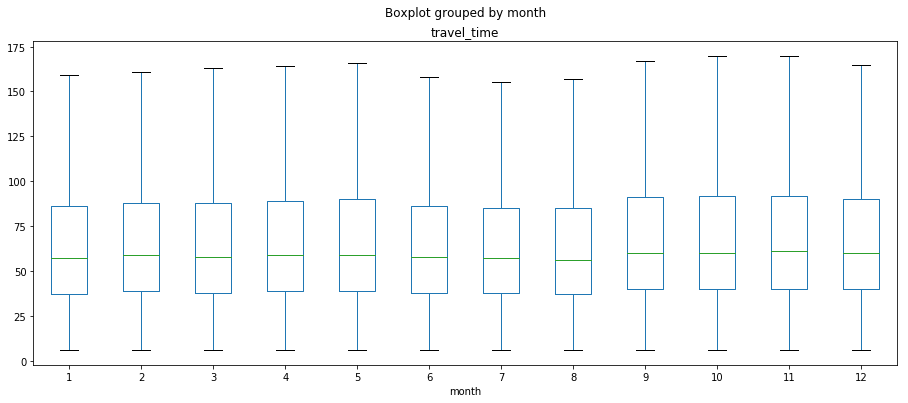

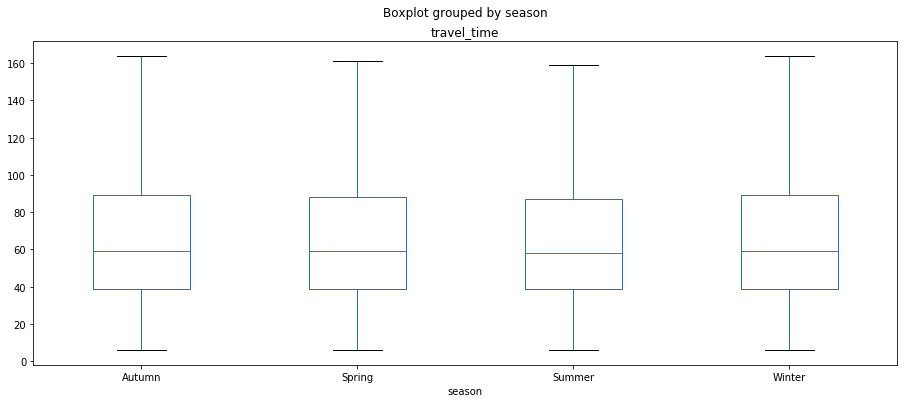

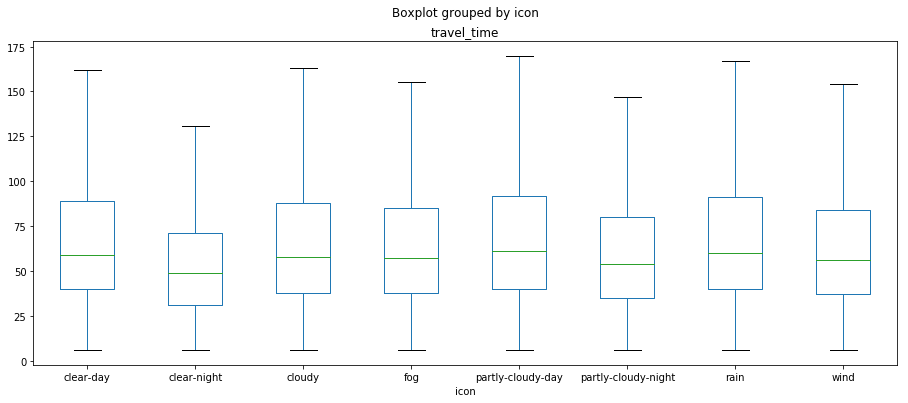

In [40]:
for cat_ft in categorical_features:
    combinedata.boxplot(column=['travel_time'], by=cat_ft, grid=False, figsize=(15,6), showfliers=False)
    plt.show()

## Encoding categorical data

#### Season Categories

In [41]:
combinedata.season = combinedata.season.astype('category', categories=['Summer','Spring','Autumn','Winter'])

combinedata = pd.concat([combinedata, pd.get_dummies(combinedata.season, prefix='season')], axis=1)
combinedata.drop(columns=['season'], inplace=True)

#### Icon Categories

In [42]:
combinedata.icon = combinedata.icon.astype('category', categories=['partly-cloudy-day', 'partly-cloudy-night', 'clear-day', 'clear-night', 'rain', 'fog', 'cloudy', 'wind'])

combinedata = pd.concat([combinedata, pd.get_dummies(combinedata.icon, prefix='icon')], axis=1)
combinedata.drop(columns=['icon'], inplace=True)

### Drop all N/A values

In [43]:
gc.collect()

combinedata = combinedata.dropna() # drop na values. 
combinedata.dtypes

print("There are %d valid pairs" % combinedata.count()[0])

15133

dayofservice                datetime64[ns]
tripid                               int64
stopid                               int64
previous_stopid                      int64
actualARR                   datetime64[ns]
previous_stopARR            datetime64[ns]
temperature                        float64
humidity                           float64
windSpeed                          float64
rain                               float64
hour                               float64
weekend                               bool
holiday                               bool
travel_time                        float64
distance                             int64
avgvel                             float64
month                                int64
season_Summer                        uint8
season_Spring                        uint8
season_Autumn                        uint8
season_Winter                        uint8
icon_clear-day                       uint8
icon_clear-night                     uint8
icon_cloudy

There are 3953011 valid pairs


In [44]:
combinedata.head().T

,0,1,2,3,4
dayofservice,2018-01-01 00:00:00,2018-01-01 00:00:00,2018-01-01 00:00:00,2018-01-01 00:00:00,2018-01-01 00:00:00
tripid,5955476,5955476,5955476,5955476,5955476
stopid,1476,7453,1478,1479,7622
previous_stopid,4320,1476,7453,1478,1479
actualARR,2018-01-01 09:01:01,2018-01-01 09:01:48,2018-01-01 09:02:52,2018-01-01 09:03:50,2018-01-01 09:05:04
previous_stopARR,2018-01-01 08:59:30,2018-01-01 09:01:01,2018-01-01 09:01:48,2018-01-01 09:02:52,2018-01-01 09:03:50
temperature,41.19,41.19,41.19,41.19,41.19
humidity,0.81,0.81,0.81,0.81,0.81
windSpeed,12.91,12.91,12.91,12.91,12.91
rain,0,0,0,0,0


In [45]:
# Updating stop pairs
# all unique stop combinations for a given lineid.
stop_pairs = combinedata[['stopid','previous_stopid']].drop_duplicates()

print("There are %d unique pairs of stops" % (stop_pairs.count()[0]))

There are 156 unique pairs of stops


## Train Models

### Setting Predictor / Target variables

In [46]:
modeldata = combinedata[['travel_time','stopid','previous_stopid','distance',
                         'temperature','humidity', 'windSpeed', 'rain', 'hour', 'holiday', 'weekend',
                         'month','season_Winter','season_Autumn','season_Summer','season_Spring',
                         'icon_clear-day', 'icon_clear-night', 'icon_cloudy', 'icon_fog',
                         'icon_partly-cloudy-day', 'icon_partly-cloudy-night', 'icon_rain','icon_wind']]
modeldata.dtypes

travel_time                 float64
stopid                        int64
previous_stopid               int64
distance                      int64
temperature                 float64
humidity                    float64
windSpeed                   float64
rain                        float64
hour                        float64
holiday                        bool
weekend                        bool
month                         int64
season_Winter                 uint8
season_Autumn                 uint8
season_Summer                 uint8
season_Spring                 uint8
icon_clear-day                uint8
icon_clear-night              uint8
icon_cloudy                   uint8
icon_fog                      uint8
icon_partly-cloudy-day        uint8
icon_partly-cloudy-night      uint8
icon_rain                     uint8
icon_wind                     uint8
dtype: object

In [47]:
# need to put this in a loop over the pairs of stops. (unique)
target     = ['travel_time']
predictors = ['temperature','humidity', 'windSpeed', 'rain', 'hour', 'holiday', 'weekend',
              'month','season_Winter','season_Autumn','season_Summer','season_Spring',
              'icon_clear-day', 'icon_clear-night', 'icon_cloudy', 'icon_fog',
              'icon_partly-cloudy-day', 'icon_partly-cloudy-night', 'icon_rain','icon_wind']

General_predictors = ['temperature','humidity', 'windSpeed', 'rain', 'hour', 
                      'holiday', 'weekend','month','distance',
                      'season_Winter','season_Autumn','season_Summer','season_Spring',
                      'icon_clear-day', 'icon_clear-night', 'icon_cloudy', 'icon_fog',
                      'icon_partly-cloudy-day', 'icon_partly-cloudy-night', 
                      'icon_rain','icon_wind']

In [48]:
print("There are %d rows in model data" % (modeldata.count()[0]))
print("Average Travel Time between stops: {}".format(modeldata.travel_time.mean()))

There are 3953011 rows in model data
Average Travel Time between stops: 75.01564554209436


### General Model for stops not in the data [ will take ages to train ]

#### Filtering outliers

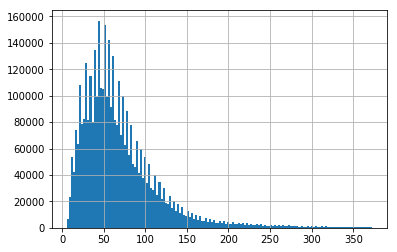

In [49]:
travel_time_deviation = modeldata.travel_time.std()

# Only allow travel times greater than zero 
General_modeldata = modeldata[modeldata.travel_time >= 0]

# Filter outliers from the dataset
General_modeldata = General_modeldata[abs(General_modeldata.travel_time-General_modeldata.travel_time.mean()) < 3*travel_time_deviation]

# Show spread of data
General_modeldata.travel_time.hist(bins=150)

#### Test train split

In [50]:
# ========================= Test/Train Splits ========================== #
General_X_train, General_X_test, General_y_train, General_y_test = train_test_split(General_modeldata[General_predictors],
                                                                                     General_modeldata[target].values.ravel(), 
                                                                                     test_size=0.2, 
                                                                                     shuffle=True)
General_X_train.head()

,temperature,humidity,windSpeed,rain,hour,holiday,weekend,month,distance,season_Winter,...,season_Summer,season_Spring,icon_clear-day,icon_clear-night,icon_cloudy,icon_fog,icon_partly-cloudy-day,icon_partly-cloudy-night,icon_rain,icon_wind
2337010,60.70,0.69,9.18,0.0,10.0,False,False,7,1016,0,...,1,0,0,0,0,0,1,0,0,0
3866130,45.87,0.70,12.47,0.0,9.0,False,False,12,1016,1,...,0,0,0,0,0,0,1,0,0,0
430899,35.01,0.82,9.09,0.0,10.0,False,False,2,549,0,...,0,1,0,0,0,0,1,0,0,0
652722,42.98,0.56,12.91,0.0,13.0,False,True,2,373,0,...,0,1,0,0,0,0,1,0,0,0
1869702,58.99,0.57,16.64,0.0,11.0,False,False,6,737,0,...,1,0,0,0,0,0,1,0,0,0


#### Training Model

In [51]:
# ========================== Making DMatrices ========================== #
General_dtrain = xgb.DMatrix(General_X_train, label=General_y_train)
General_dtest = xgb.DMatrix(General_X_test, label=General_y_test)

# =========================== Training Model =========================== #

param = {
    'eta':0.1,
    'max_depth':6
}
num_rounds = 10000

General_model = xgb.train(param, General_dtrain, num_rounds, evals=[(General_dtest, 'Test')], verbose_eval=50, early_stopping_rounds=100)

# ============================  Predictions ============================ #
General_xgbpreds = General_model.predict(General_dtest)

# ====================== Feature Importance graph ====================== #
# xgb.plot_importance(General_model)

[0]	Test-rmse:77.3825
Will train until Test-rmse hasn't improved in 100 rounds.
[50]	Test-rmse:32.4332
[100]	Test-rmse:31.119


KeyboardInterrupt: 

### Stop Wise Models

In [ ]:
# Training Model for all pairs of stops in the dataset

models = dict()
emptys = []
metric = dict()

no_stops = stop_pairs.count()[0]
print("There are %d models to train." % no_stops)

for pair in tqdm_notebook(stop_pairs.iterrows(), desc="Progress: ", total=no_stops):

    # Travelling From A -> B
    A = pair[1][1]
    B = pair[1][0]
    
    # ========================= Rows from A -> B =========================== #
    data = modeldata[(modeldata.stopid==B)&(modeldata.previous_stopid==A)]
    
    if data.count()[0] > 10:
    
        # ========================= Removing Outliers ========================== #
        travel_sigma = data.travel_time.std()

        # Only allow travel times greater than zero 
        data = data[data.travel_time >= 0]

        # Filter outliers from the dataset [ 2σ as the cutoff ~95% of data ]
        data = data[abs(data.travel_time - data.travel_time.mean()) < 2*travel_sigma]

        # ========================= Remove Null Data =========================== #
        data.dropna(inplace=True)

        # ========================= Test/Train Splits ========================== #
        X_train, X_test, y_train, y_test = train_test_split(data[predictors],data[target].values.ravel(), test_size=0.3, shuffle=True)

        # ========================== Making DMatrices ========================== #
        dtrain = xgb.DMatrix(X_train, label=y_train)
        dtest = xgb.DMatrix(X_test, label=y_test)

        # =========================== Training Model =========================== #

        param = {
            'eta': 0.15,
            'max_depth': 6
        }

        num_rounds = 10000

        try:
            
            # ============ Train ============= #
            model = xgb.train(param, dtrain, num_rounds, evals=[(dtest, 'Test')], verbose_eval=False, early_stopping_rounds=100)
            models[f'{A}_{B}'] = model
            
            # ============ Testing Accuracy ========== #
            preds = model.predict(dtest)
            metric[f'{A}_{B}'] = dict()
            metric[f'{A}_{B}']['rmse'] = np.sqrt(metrics.mean_squared_error(preds, y_test))
            metric[f'{A}_{B}']['preds']= preds
            metric[f'{A}_{B}']['ytest']= y_test
            
            
        except Exception as e:
            print(f"Error with route: {A} -> {B}")
            data.head()
            y_train, y_test
            print(repr(e), end='\n================================================\n')
    else:
        print(f"Empty Set Error: {A} -> {B}")
        emptys.append((A,B))

## Evaluate Models

### General Model

#### Plotting Errors

In [ ]:
# ========================= Visualising Errors ========================= #
General_xgbresiduals = General_xgbpreds - General_y_test

# best fit of data
(xmu, xsigma) = stats.norm.fit(General_xgbresiduals)

# # The histogram of the data
xn, xbins, xpatches = plt.hist(General_xgbresiduals, 100, density=True, facecolor='blue', alpha=0.6)

# add a 'best fit' line
xy = mlab.normpdf(xbins, xmu, xsigma)
xl = plt.plot(xbins, xy, 'r--', linewidth=2)
plt.show()

print(xsigma,xmu)

#### Cross Validation

In [ ]:
General_rmse = np.sqrt(metrics.mean_squared_error(General_xgbpreds, General_y_test))

print(f"""
General Model RMSE: {General_rmse}
""")


### Individual Models

In [ ]:
scores_sample = []
for key in metric.keys():
        
    scores_sample.append(metric[key]['rmse'])
    
    if metric[key]['rmse'] > 50:
        
        plt.figure()
        plt.title("{} - {}".format(key, metric[key]['rmse']))
        plt.plot(metric[key]['preds'],'r')
        plt.plot(metric[key]['ytest'],'b', alpha=0.5)

plt.figure(figsize=(20,5))
plt.plot(scores_sample, 'b.')
plt.axhline(y=30)
plt.show()

## Exporting Model

In [ ]:
# Exporting General Model

General_model.save_model("ModelFiles/StopModels/General.model")


# Exporting all models 
    
mkeys = list(models.keys())

for k in tnrange(len(mkeys)):
    
    key = mkeys[k]
    
    models[key].save_model(f"ModelFiles/StopModels/{key}.model")